# Introduction to Decision Tree

-----

In this Notebook, we introduce the [Decision Tree algorithm][wdt], and demonstrate how to effectively use this algorithm for both classification and regression problems. The Decision Tree algorithm is a simple algorithm that is easy to understand, since a higher-level representation of the data is iteratively constructed from the data. A decision tree provides a powerful, predictive model that can capture non-linear effects while also being easy to understand and explain. 

In this notebook, we first explore the basic formalism of the decision tree algorithm, including a discussion on several important concepts that can be used to determine how the tree is constructed from a data set. Next, we introduce the use of the decision tree for classification problems by using the Iris data set. In this section we will examine feature importance, visualize the predictive tree, and discuss the effect of different hyperparameters, before switching to a more complex data set. Then, we will look at constructing a decision tree for regression, by using a new data set. Finally, we will briefly introduce several popular regression performance metrics.

-----
[wdt]: https://en.wikipedia.org/wiki/Decision_tree_learning

## Table of Contents

[Formalism](#Formalism)

[Decision Tree: Classification](#Decision-Tree:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Decision Tree: Feature Importance](#Decision-Tree:-Feature-Importance)
- [Decision Tree: Visualizing the Tree](#Decision-Tree:-Visualizing-the-Tree)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Decision Tree: Regression](#Decision-Tree:-Regression)

- [Regression: Auto MPG Data](#Regression:-Auto-MPG-Data)

[Regression Performance Metrics](#Regression-Performance-Metrics)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----


In [1]:
# Set up Notebook
%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the simplest machine learning algorithms to understand is the [decision tree][wdt]. For a classification task, a decision tree asks a set of questions of the data, and based on the answers, determines the final classification. The tree is constructed by recursively splitting a data set into new groupings based on a statistical measure of the data along each different dimension. The terminal nodes in the tree are known as leaf nodes and provide the final predictions. In the simplest form, the leaf node simply provides the final answer; however, the values in the leaf node can also be combined to form a probabilistic classification or regression estimate.

In addition to their simplicity, decision trees have several other benefits. First, they are a _white box model_, which simply means we can understand exactly why a decision tree makes a specific prediction on a given instance. Second, they can handle both numerical and categorical data, and they do not require pre-processing beyond handling missing values. Trees also tend to perform well on large data sets. 

On the other hand, decision trees are prone to **overfitting**, where they model the training data too well and do not generalize to unseen data. Decision trees can have difficulty classifying on unbalanced classes and they can be unstable to minor changes in the training data. Overall, however, the decision tree is one of a handful of standard machine learning algorithms with which you should be familiar. In future notebooks, we will learn how to overcome many of these disadvantages by employing ensemble learning with decision trees. 

The following figure shows a simple decision tree. In the image below, the square text box represents a condition, based on which the tree splits into branches. The end of the branch represented by oval text box that doesn’t split anymore is the leaf, or decision; in this case, whether one should wear sunglasses or not.

<img src="images/dt_sunglasses.png">
   
The decision on which feature to split, and the actual value along that feature on which to split can be performed in several different manners:
- [Variance reduction][wvr]: the split choice is made to maximally reduce the variance along a feature, useful for regression problems.
- [Gini impurity][wgi]: the split choice is made to minimize misclassifications, especially in a multi-class classification domain.
- [Information gain][wig]: the split choice is selected to create the purest child nodes, based on the concept of entropy and information theory.

The detail of spliting algorithms is out of the scope of this course.

-----

[wdt]: https://en.wikipedia.org/wiki/Decision_tree_learning

[wvr]: https://en.wikipedia.org/wiki/Decision_tree_learning#Variance_reduction
[wig]: https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain
[wgi]: https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

-----

[[Back to TOC]](#Table-of-Contents)

## Decision Tree: Classification

To apply the decision tree algorithm to classification tasks we will use the `DecisionTreeClassifier` estimator from the scikit-learn `tree` module. This estimator will construct, by default, a tree from a training data set. This estimator accepts several hyperparameters, including:

- `criterion`: The method by which to measure the quality of a potential split. By default the Gini impurity is used, although information gain can be specified by passing the string `entropy`.
- `max_depth`: The maximum depth of the tree. By default this is `None`, which means the tree is constructed until either all leaf nodes are pure, or all leaf nodes contain fewer instances than the `min_samples_split` hyperparameter value.
- `min_samples_split`: The minimum number of instances required to split a node into two child nodes. By default this value is two.
- `min_samples_leaf`: The minimum number of instances required to make a node terminal (i.e., a leaf node). By default this value is one.
- `max_features`: The number of features to examine when choosing the best split feature and value. By default this is `None`, which means all features will be explored.
- `random_state`: The seed for the random number generator used by this estimator. Setting this value ensures reproducibility.
- `class_weight`: Values that can improve classification performance on unbalanced data sets. By default this value is `None`.

Run `help(DecisionTreeClassifier)` to view more details about the model and the hyperparameters.

To demonstrate using a decision tree with the scikit-learn library, we will first load in the Iris data. With these data, we will construct a simple decision tree to introduce the concept of _feature importance_. Next, we will explore how to visualize the decision tree constructed by the `DecisionTreeClassifier` estimator. Finally, we will switch to a larger data set to learn how to employ a decision tree on more complex data.

----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

[[Back to TOC]](#Table-of-Contents)

### Classification: Iris Data

We can now apply the Decision Tree algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Load Iris data
2. Encode species column to create a numeric label column.
3. Split the data into training and testing sets.
4. Import our estimator, [`DecisionTreeClassifier`][skdtc], from the proper scikit-learn module, `tree`.
5. Create the estimator and specify the appropriate hyperparameters. For a decision tree, we can accept the defaults, or specify values for specific hyperparameters, such as `max_depth`.
6. Fit the model to the training data.
7. Predict new classes with our trained model and generate performance metrics.

These steps are demonstrated in the following code cells.

We will also plot a confusion matrix for the model using helper code. The helper code defines `confusion()` function. You may find the source code of `confusion()` in previous lesson notebook.

-----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [2]:
iris_df = pd.read_csv('iris.csv')
iris_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
5,5.4,3.9,1.7,0.4,setosa
20,5.4,3.4,1.7,0.2,setosa
55,5.7,2.8,4.5,1.3,versicolor
79,5.7,2.6,3.5,1.0,versicolor
35,5.0,3.2,1.2,0.2,setosa


In [3]:
from sklearn.preprocessing import LabelEncoder
#create new column to hold encoded species
iris_df['species_cat'] = LabelEncoder().fit_transform(iris_df.species)
iris_df.sample(5, random_state=1)

,sepal_length,sepal_width,petal_length,petal_width,species,species_cat
14,5.8,4.0,1.2,0.2,setosa,0
98,5.1,2.5,3.0,1.1,versicolor,1
75,6.6,3.0,4.4,1.4,versicolor,1
16,5.4,3.9,1.3,0.4,setosa,0
131,7.9,3.8,6.4,2.0,virginica,2


In [4]:
from sklearn.model_selection import train_test_split
#Define data and label
data = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
label = iris_df['species_cat']

# Split data into training and testing
# Note that we have both 'data' and 'label'
d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)
d_train.shape, d_test.shape

((90, 4), (60, 4))

In [5]:
#check training label balance
l_train.value_counts()

1    32
2    29
0    29
Name: species_cat, dtype: int64

In [6]:
#check testing label balance
l_test.value_counts()

2    21
0    21
1    18
Name: species_cat, dtype: int64

In [7]:
# Next lets try Decision Trees
from sklearn.tree import DecisionTreeClassifier

# First we construct our decision tree, we only specify the 
# random_state hyperparameter to ensure reproduceability.
dtc = DecisionTreeClassifier(random_state=23)

# Fit estimator to scaled training data
dtc = dtc.fit(d_train, l_train)

# Compute and display accuracy score
score = 100.0 * dtc.score(d_test, l_test)
print(f"Decision Tree prediction accuracy = {score:4.1f}%")

Decision Tree prediction accuracy = 96.7%


-----

For completeness, we also display the classification report and the confusion matrix in the following two Code cells. The per-class precision and recall are very good, with a minor issue in the prediction of class `Virginica`, which is also demonstrated clearly in the confusion matrix.

-----

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = dtc.predict(d_test)
print(classification_report(l_test, y_pred, target_names = labels))
print('Primitive Confusion Matrix:')
print(confusion_matrix(l_test, y_pred))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.90      1.00      0.95        18
   Virginica       1.00      0.90      0.95        21

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Primitive Confusion Matrix:
[[21  0  0]
 [ 0 18  0]
 [ 0  2 19]]


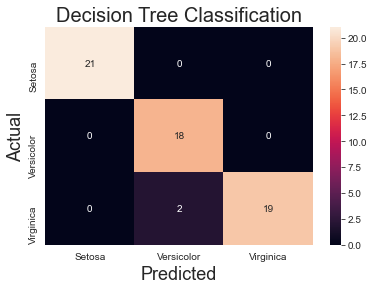

In [9]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test, y_pred, labels, 'Decision Tree Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree: Feature Importance

As the previous example demonstrated, the decision tree can often provide impressive performance rather easily. We can, however, leverage the fact that the decision tree is constructed by repeatedly determining the most important feature on which to split the data to compute the relative importance of each feature in the training data set. In effect, this is computed by determining to what percentage each feature was used to split the training data; formally this is known as the _Gini importance_. As a result, higher values indicate a more important feature. 

We demonstrate how to extract the feature importance for a decision tree classifier in the following Code cell, where we see that for this training data set, two features: Petal Width and Petal Length account for most of the importance.

----

In [10]:
# Display feature importance as computed from the decision tree

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, dtc.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Sepal Length importance =  1.67%
Sepal Width importance =  2.22%
Petal Length importance =  5.59%
Petal Width importance = 90.51%


-----

[[Back to TOC]](#Table-of-Contents)

### Decision Tree: Visualizing the Tree

A decision tree is one of the easiest algorithms to understand since a decision tree essentially asks a list of questions to partition the data. The scikit-learn library includes an [`export_graphviz`][sket] method that actually generates a visual tree representation of a constructed decision tree classifier. This representation is in the [`dot`][dot] format recognized by the standard, open source [`graphviz`][gv] library. 

In the next few Code cells, we export a _dot_ format of the Iris decision tree we just constructed, convert it to an SVG image, and subsequently display this image inline in our notebook. Note, if the _graphviz_ module was available, we could generate and display the decision tree directly in our notebook as demonstrated in the comments of the third Code cell below.

-----
[sket]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz
[dot]: http://www.graphviz.org/doc/info/lang.html
[gv]:http://www.graphviz.org

In [11]:
# First we construct our a shallow decision tree, this is
# simply a demonstration used to show feature improtance
# and how to view a tree, hence we need a shallow tree with max_depth=3
dtc = DecisionTreeClassifier(max_depth=3, random_state=23)

dtc = dtc.fit(d_train, l_train)

-----

Note, this decision tree classifier is different than our original decision tree classifier since we set the `max_depth` hyperparameter to three. We display the feature importance for this new tree to compare to our original feature importance. In this case, we see that the two features we identified before are exclusively used to construct the new tree. Thus, we can infer that the original tree first used these two features to split the training data, before using the other two features to make leaf nodes.

-----

In [12]:
# Display feature importance as computed from the decision tree

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, dtc.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Sepal Length importance =  0.00%
Sepal Width importance =  0.00%
Petal Length importance =  4.82%
Petal Width importance = 95.18%


---

The version of scikit-learn we can use in this class currently limits our ability to control the appearance of the tree. If you have [graphivz](https://pypi.org/project/graphviz/) installed, you can simply perform the following steps to create and visualize a tree in a Jupyter notebook:

```
import graphviz
from sklearn.tree import export_graphviz
tree_data = export_graphviz(dtc, out_file=None, feature_names=feature_names) 
my_tree = graphviz.Source(tree_data) 
my_tree 
```

In this notebook, we will simply display the image of the tree.

We now display the generated tree visualization, and see that, as expected, the Petal Width feature is used for the primary splits, (indicating it is more important), while the Petal length feature is used to split into leaf nodes. 


---

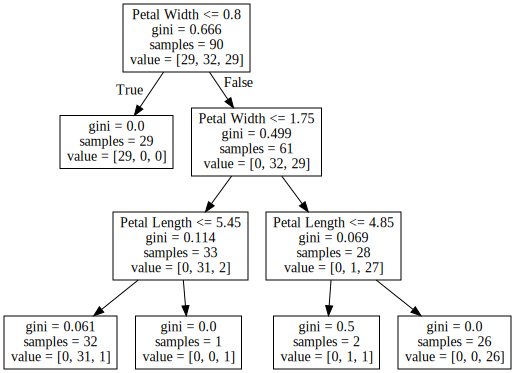

In [13]:
# Now display the image inline
from IPython.display import SVG
SVG(filename='tree.svg')

-----

<font color='red' size = '5'> Student Exercise </font>

In the following blank Code cell, try create decision tree classfiers with different `max_depth` and apply the models on iris dataset. Compare the model accurracy for different `max_depth` values.

-----

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform classification by using a decision tree. We will use the [Adult Income Dataset][uciad] introduced in the previous lesson notebook. We will choose `Age`, `HoursPerWeek`, `CapitalGain` and `Sex` as our training data to predict income level as we did in previous lesson.

In the following two Code cells, we first prepare data. Note that decision tree can handle categorical feature directly so we don't need to create dummy features for categorical features. But we still need to encode the categorical features if the values are string. We will use LabelEncoder to encode the `Sex` column.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [14]:
# Read CSV data
adult_data = pd.read_csv('data/adult_income.csv')

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Encode Sex column to numerical value
adult_data['Sex_code'] = LabelEncoder().fit_transform(adult_data.Sex)

data = adult_data[`]
label = adult_data['Label']

#display label class count
print(label.value_counts())
# Display random sample
data.sample(5)

SyntaxError: invalid syntax (<ipython-input-14-df3cf6b36d85>, line 10)

-----

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our decision tree classifier, and then measure its performance on our testing data. 

In the first Code cell, we start by splitting our data into training and testing samples. Next, we create the `DecisionTreeClassifier` estimator. The only hyperparameter that we specify at this time is `random_state` in order to ensure reproducibility. Next, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. The report indicates that our model performs worst in predicting the positive class. Specifically, the recall indicates that we incorrectly label positive targets as negative. This means that our classifier incorrectly labels individuals who do earn a high salary as being in the low salary category.

In the third Code cell, we plot the confusion matrix.

Decision tree model has a feature importances attribute, which nicely shows the impact of each feature on the model. In the fourth Code cell, we create a DataFrame with two columns, Feature and Importance, from training data column names, and the feature importances attribute of the model. We create the DataFrame to make it easier to display feature importance in descending order.


----

In [ ]:
from sklearn.model_selection import train_test_split

d_train, d_test, l_train, l_test = train_test_split(data, label, test_size=0.4, random_state=23)

adult_model = DecisionTreeClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [ ]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print(f'Classification Report:\n {metrics.classification_report(l_test, predicted)}\n')

In [ ]:
from helper_code import mlplots as ml
ml.confusion(l_test, predicted, ['low', 'high'], title='Decision Tree Classification')

In [ ]:
feature_importance = pd.DataFrame(list(zip(d_train.columns, adult_model.feature_importances_)),
                                  columns=['Feature', 'Importance'])
feature_importance.sort_values(by='Importance', ascending=False)

The decision tree classifier has a little worse accuracy rate than that of the logistic regression introduced in the previous lesson. But it has better recall rate on high income(class 1) prediction, which means it identified more high income correctly than the logistic regression model. You can compare the confusion matrix of the two models for more detail.


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a decision tree for classification and applied it to the adult income prediction task. Try making the following changes to see if you can do better.

1. Change the features used in the classification; for example add one or more columns such as Relationship and Education. Do the results change? 
2. Try setting the `class_weight` hyperparameter to `balanced` to aid in dealing with the unbalanced training data.

-----

[[Back to TOC]](#Table-of-Contents)

## Decision Tree: Regression

A decision tree can also be used to perform regression. To perform regression with the scikit-learn library we employ the [`DecisionTreeRegressor`][skdtr] estimator in the tree module. This estimator employs the same set of hyperparameters as the `DecisionTreeClassifier` estimator, and is, therefore, used in a similar manner. One other point, which is also true for classification, by specifying the `random_state` hyperparameter, we ensure reproducibility. This is because every time a tree is constructed, the features are always randomly  permuted at every split. Thus, even if we use the same set of hyperparameters and the same set of training data, we can end up with different trees if the `random_state` hyperparameter is not fixed.

In this section we employ decision trees to perform regression on a new data set, the automotive fuel performance prediction. First, we will introduce the data, and prepare them for the regression task. Next, we will employ the patsy module to use a regression formula to create our dependent and independent feature matrices. Finally, we will construct a decision tree regressor on these data and evaluate its performance.


-----

[skdtr]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

The automobile fuel performance prediction data were collated by Ross Quinlan and released in 1993. The data contains nine features: mpg, cylinders, displacement, horsepower, weight, acceleration, model_year, origin, and car name. Of these, the first is generally treated as the dependent variable (i.e., we wish to predict the fuel efficiency of the cars), while the next seven features are generally used as the independent variables. The last feature is a string that is unlikely to be useful when predicting on new, unseen data, and is, therefore, not included in our analysis.

Of these features, three are discrete: cylinders, model_year, and origin; and four are continuous: 
displacement, horsepower, weight, and acceleration. 

In the first two Code cells, we load the dataset, then print 5 sample rows and the basic information of the dataframe.

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [ ]:
auto_data = pd.read_csv('mpg.csv')
auto_data.sample(5)

In [ ]:
auto_data.info()

-----

From the dataframe information, we can see that horsepower column has some missing values. We will have to deal with missing values since the decision tree model(as well as most other machine learning models) doesn't work with missing values. We have several options here: simply drop the missing values and fill them with values like mean of the column, or estimate with the help of other features(imputing). But first, let's visualize the relations among all continuous features with `seaborn pairplot`. In the next Code cell, we plot pairplot for the four continuous features. 

We can see that horsepower is pretty much positively correlated with weight and displacement, which is understandable. In regression, when multiple features are highly correlated, multicollinearity occurs. Multicollinearity causes problems when you fit the model and interpret the results. A simple way to fix multicollinearity is to drop the highly correlated features. When the correlation of two features is greater than 0.8, they are considered as highly correlated. To quantify feature correlations, we display the correlation matrix of the continuous features in the next Code cell. We will drop both horsepower and weight, since they both are highly correlated with displacement. Since we decide to drop horsepower, we don't have to handle missing values in the feature.

In the third Code cell, we encode the origin column and define the dependent and independent variables.

-----


In [ ]:
sns.pairplot(data=auto_data[['displacement', 'horsepower', 'weight', 'acceleration']])

In [ ]:
auto_data[['displacement', 'horsepower', 'weight', 'acceleration']].corr()

In [ ]:
#Encode origin
auto_data['origin_code'] = LabelEncoder().fit_transform(auto_data.origin)
#Choose dependent variable and independent variable.
y = auto_data['mpg']
#Drop horsepower and weight from independent variables
x = auto_data[['cylinders', 'displacement', 'acceleration', 'model_year', 'origin_code']]

-----

With the dependent and independent variables ready, we can now build a regressive model. 

First, we import the `DecisionTreeRegressor` before splitting our independent and dependent variables into training and testing samples. 

Then, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. 

Next, we fit the model and display a predictive score. The model achieved a pretty good score or $R^2$ at 73.7%.

Then, we display the feature importance which shows that displacement is the most important feature when predicting mpg.

Finally, we compute a number of different regression performance metrics and displays the results. Notice that, unlike the case for classification, regression performance metrics(except for $R^2$) are generally better when they are smaller. This is because these metrics are often quantifying the difference between the test and predicted features, which we want to minimize. We will discuss regression performance metrics in more details in future lessons.

-----

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=0.4, random_state=23)

# Create Regressor with default properties
auto_model = DecisionTreeRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print(f'Score = {auto_model.score(ind_test, dep_test):.1%}')

In [ ]:
auto_model.feature_importances_
feature_importance = pd.DataFrame(list(zip(ind_train.columns, auto_model.feature_importances_)), columns=['Feature', 'Importance'])
feature_importance.sort_values(by='Importance', ascending=False)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mr2 = r2_score(dep_test, pred)
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)

# Display metrics
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Mean Absolute Error   = {mae:4.2f}')

[[Back to TOC]](#Table-of-Contents)

## Regression Performance Metrics

There are many ways to measure the performance of a regression model. In above code, to evaluate the model, we printed the $R^2$ score, mean absolute error and mean squared error. We will discuss these terms briefly below.

Regression performance metrics are a very import concept; we will explore them in more details in future lessons.

#### R-squared ($R^2$)
R-squared($R^2$), also known as the Coefficient of Determination, is the most commonly known evaluation metric for a regression model. It is the proportion of variation in the outcome(dependent variable) that is explained by the predictor variables(independent variables). R^2 normally ranges from 0 to 1. The Higher the R-squared, the better the model.

#### Mean Squared Error (MSE)
Mean squared error (MSE) is the average squared difference between the observed actual outcome values and the values predicted by the model. So, $MSE = mean((observeds - predicteds)^2)$. The lower the MSE, the better the model.

#### Mean Absolute Error (MAE)
Mean Absolute Error (MAE) is the average absolute difference between observed and predicted outcomes, $MAE = mean(abs(observeds - predicteds))$. MAE is less sensitive to outliers compared to MSE. The lower the MAE, the better the model.

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a decision tree for regression and applied it to the automobile fuel performance prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

1. Change the features used in the regression, for example drop one column, such as `origin`. Do the results change? 

-----


## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. A detailed [blog article][1] on decision trees and computing split features
1. A presentation style web article on [building decision trees][2] with scikit-learn
2. An article on [building decision trees][3] from scratch in Python at Analytics Vidhya
12. A readable article on [building and using][4] decision trees in Python

-----
[1]: https://web.archive.org/web/20170628054712/http://decisiontrees.net/decision-trees-tutorial/tutorial-4-id3/

[2]: http://www.ritchieng.com/machine-learning-decision-trees/

[3]: https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

[4]: https://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 